In [2]:
import tensorflow as tf
import os
import warnings 
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tools.eval_measures import meanabs, rmse
from statsmodels.tools.eval_measures import meanabs
from sklearn.preprocessing import MinMaxScaler
import gc
import math as mt
from IPython.display import display
import tensorflow_probability as tfp

from tensorflow_probability import bijectors as tfb
from tensorflow_probability import distributions as tfd

warnings.filterwarnings('ignore')

### About

This is more of an experimental approach to forecasting Crypto (volatile) using probabilistic models --> Bayesian Inference combined with Neural Nets

In [3]:
import pickle

dict_file = open('/kaggle/input/btc-private/BTC_dict_data(last_btc_520k).pkl', 'rb')
df_btc = pickle.load(dict_file)
dict_file.close()

df_btc.index = pd.date_range('2020-12-28', periods = len(df_btc), freq='min') # use freq = 'min' to get minute data

517065


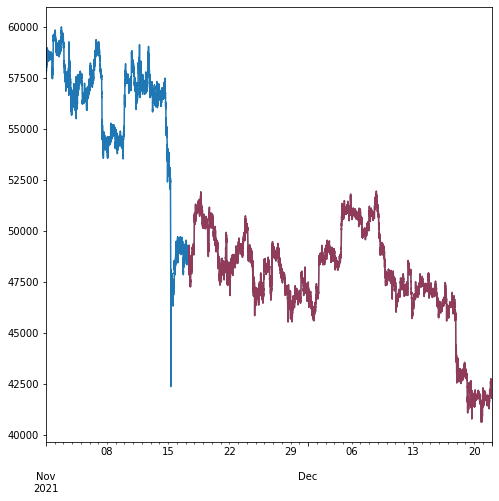

In [4]:
print(len(list(df_btc.index)))
df_btc.loc['2021-11-1':].Close.plot(figsize=(8,8)) #localising recent past 
df_btc.iloc[-50000:].Close.plot(figsize=(8,8), c='red', alpha=0.5)
plt.show()

In [5]:
new_col_order = ['Count','Open','High','Low','Volume','Target','Close']
baye_col = ['Close']

display(df_btc.head())
df_btc = df_btc.reindex(columns = baye_col)
display(df_btc.head())

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
2020-12-28 00:00:00,1,957.0,36206.861429,36229.65,36190.19,36208.728571,41.432349,36209.592593,0.007300
2020-12-28 00:01:00,1,1339.0,36205.925714,36218.16,36158.59,36177.964286,59.714065,36186.969622,0.006348
2020-12-28 00:02:00,1,1236.0,36177.438571,36200.00,36123.71,36145.848571,43.223924,36157.861039,0.006707
2020-12-28 00:03:00,1,1198.0,36148.634286,36186.86,36130.31,36168.898571,45.372270,36153.545036,0.007882
2020-12-28 00:04:00,1,1099.0,36169.975714,36204.02,36151.90,36178.573177,67.231590,36176.096194,0.009148


,Close
2020-12-28 00:00:00,36208.728571
2020-12-28 00:01:00,36177.964286
2020-12-28 00:02:00,36145.848571
2020-12-28 00:03:00,36168.898571
2020-12-28 00:04:00,36178.573177


We can preprocess the closing prices by making the evolution <b> stationary </b> | Statsmodels | Otherwise, Forces a significant bottleneck on the data

(22000,)


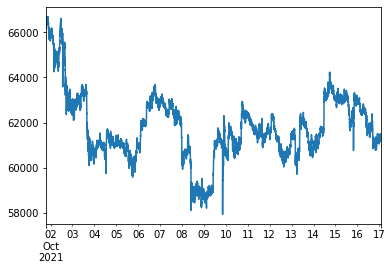

In [6]:
samples_taken_st = 400000
samples_taken_end = 420000

future_push = 2000
total_samples = samples_taken_end + future_push

df_btc.iloc[samples_taken_st: total_samples].Close.plot()
x_obs = df_btc.iloc[samples_taken_st: total_samples].Close.to_numpy().astype('float32')
print(x_obs.shape)

#### Custom-scaling

In [55]:
def min_max_scale(data, new):
    
    new_min, new_max = new
    
    min_values = np.min(data, axis=0)
    max_values = np.max(data, axis=0)

    scaled_data = (data - min_values) * (new_max - new_min) / (max_values - min_values) + new_min

    return scaled_data, min_values, max_values

def descale(scaled_data, new_min, new_max):
    
    min_values = np.min(scaled_data, axis=0)
    max_values = np.max(scaled_data, axis=0)

    original_data = (scaled_data - min_values) * (new_max - new_min) / (max_values - min_values) + new_min
    
    return original_data

57935.598 66691.31
Descaled:  57935.598 66691.31
(20000, 1) Scaled:  10.0 100.0


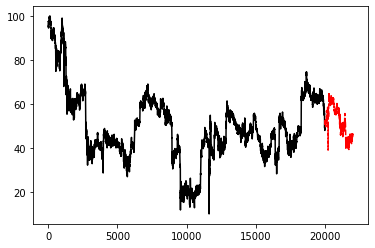

In [56]:
new = 10, 100

x_obs_scaled, min_og, max_og = min_max_scale(x_obs, new)
x_obs_scaled = x_obs_scaled.reshape(-1, 1)

print(min_og, max_og)

x_obs_descaled = descale(x_obs_scaled, min_og, max_og)
print('Descaled: ', np.min(x_obs_descaled), np.max(x_obs_descaled))
# x_obs_scaled = np.squeeze(min_max_scale(x_obs.reshape(-1, 1), new))


x_obs_test_scaled = x_obs_scaled[-future_push:].reshape(-1, 1)
x_obs_scaled = x_obs_scaled[: -future_push].reshape(-1, 1)


print(x_obs_scaled.shape, 'Scaled: ', min(np.ravel(x_obs_scaled)), max(np.ravel(x_obs_scaled)))

plt.plot(np.arange(0, len(x_obs_scaled)), x_obs_scaled, 'k')
plt.plot((len(x_obs_scaled) + 1) + np.arange(0, len(x_obs_test_scaled)), x_obs_test_scaled, 'r--')
plt.show()

In [33]:
seed = 28
np.random.seed(seed)


def Data_func(data, past, delay, minn, maxx = None, shuffle=False, batch_size=128, rate=6):
    if maxx is None:
        maxx = len(data) - delay -1
    i = minn + past
    batch_no = 1

    while True:

        if shuffle:
            rows = np.random.randint(minn + past, maxx, size = batch_size)
        else:
            rows = np.arange(i, min(i + batch_size, maxx))
        
        i+=len(rows)
        if i + batch_size > maxx: ## when you increase the past too much this statement gets executed at the first batch creation // add more data to overcome
            break
        
        samples = np.zeros((len(rows), past // rate, data.shape[-1]))
        targets = np.zeros((len(rows),))
        cbase_preds = np.zeros((len(rows),))
    
        for j, row in enumerate(rows):
            
            indices = range(rows[j] - past, rows[j], rate) ## take every point
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay - 1][-1]
       
        if batch_no == 1:
            print('im here')
            new_sample = samples
            new_targets = targets
            print('Ini_samples: ', samples.shape, 'Ini_targets: ', targets.shape)
        else:
            new_sample = np.concatenate([new_sample, samples], axis=0)
            new_targets = np.concatenate([new_targets, targets], axis=0)
        batch_no+=1
        
    return new_sample, new_targets


past = 360 #  6 hours in past {Localised}
delay = 0 # 0s diff into the future, no delay

train_split, test_split = 0.70, 0.30
train_max = round(train_split * x_obs_scaled.shape[0])
val_max = (1-train_split)*x_obs_scaled.shape[0]
test_max = round(test_split*val_max)
val_max = round(val_max - test_max)
batch_size = 32

mean = x_obs_scaled[:train_max].mean(axis = 0)
x_train = x_obs_scaled - mean
std = x_train[:train_max].std(axis = 0)
x_train /= std

print(x_train.shape)
print(min(x_train), max(x_train))

 ## sampling data every 5 minute
train_data, train_target = Data_func(x_train, past, delay, minn = 0, maxx = train_max - 1, batch_size = batch_size, shuffle=True, rate=6)
val_data, val_target = Data_func(x_train, past, delay, minn = train_max + 1, maxx = train_max + val_max - 1, batch_size = batch_size, rate=6)
test_data, test_target = Data_func(x_train, past, delay, minn = train_max + val_max + 1, maxx = train_max + val_max + test_max, batch_size = batch_size, rate = 6)

print('Shape -- ')
print(train_data.shape, train_target.shape, val_data.shape, val_target.shape, test_data.shape, test_target.shape)

print(min(np.ravel(train_data)), max(np.ravel(train_target)))
print(min(np.ravel(val_data)), max(np.ravel(val_target)))
print(min(np.ravel(test_data)), max(np.ravel(test_target)))


(20000, 1)
[-2.2181559] [2.8621476]
im here
Ini_samples:  (32, 60, 1) Ini_targets:  (32,)
im here
Ini_samples:  (32, 60, 1) Ini_targets:  (32,)
im here
Ini_samples:  (32, 60, 1) Ini_targets:  (32,)
Shape -- 
(13600, 60, 1) (13600,) (3776, 60, 1) (3776,) (1376, 60, 1) (1376,)
-2.218155860900879 2.815561532974243
-1.1877857446670532 0.4012977182865143
-0.17183074355125427 1.4345871210098267


#### Normalization

In [34]:
def inv_norm(test_target):
    test_target = np.ravel(test_target)
    test_target = test_target * std[-1]
    test_target = test_target + mean[-1]
    return test_target

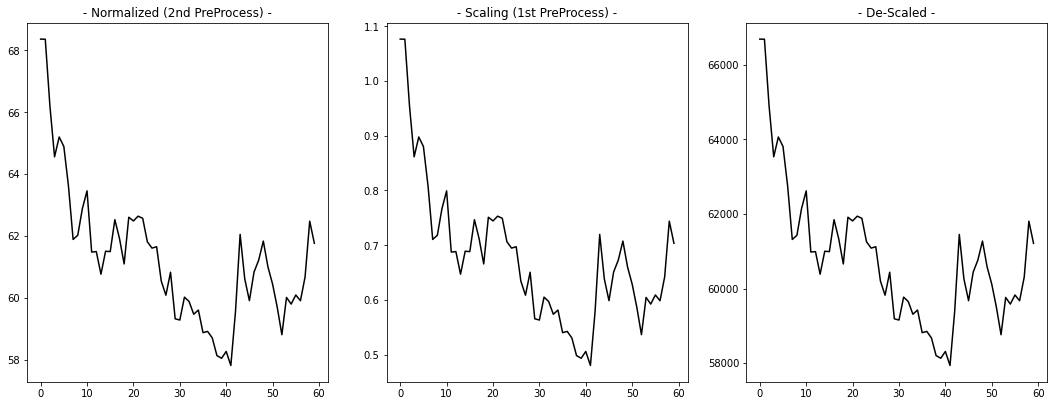

In [92]:
sample_seed = 5

fig, axs = plt.subplots(1, 3, figsize = (15, 6))

axs[1].plot(np.arange(0, len(train_data[sample_seed])), np.squeeze(train_data[sample_seed]), 'k')
axs[1].set_title(' - Scaling (1st PreProcess) - ')

axs[0].plot(np.arange(0, len(train_data[sample_seed])), inv_norm(np.squeeze(train_data[sample_seed])), 'k')
axs[0].set_title(' - Normalized (2nd PreProcess) - ')

axs[2].plot(np.arange(0, len(train_data[sample_seed])), descale(inv_norm(np.squeeze(train_data[sample_seed])), min_og, max_og), 'k')
axs[2].set_title(' - De-Scaled - ')

plt.tight_layout(pad = 2)
plt.show()

#### Structural-TS Workflow | Local-Linear-Trend <br>
TensorFlow (Exact) time-series implementation

In [110]:
x_obs_scaled = x_obs_scaled[:200].reshape(-1, 1)
print(x_obs_scaled.shape)

(200, 1)


In [111]:
num_timesteps = len(x_obs_scaled)

def build_model(approximate_unconstrained_rates):
    trend = tfp.sts.LocalLinearTrend(
      observed_time_series=approximate_unconstrained_rates)
    return tfp.sts.Sum([trend],
                     observed_time_series=approximate_unconstrained_rates)

positive_bijector = tfb.Softplus()  

approximate_unconstrained_rates = positive_bijector.inverse(tf.convert_to_tensor(x_obs_scaled))
sts_model = build_model(approximate_unconstrained_rates)

def sts_with_poisson_likelihood_model():
    # Encode the parameters of the STS model as random variables.
    param_vals = []
    for param in sts_model.parameters:
        param_val = yield param.prior
        param_vals.append(param_val)

    ''' WE yield only those R.V whose Joint-distrib we want to find'''    
        
    ## instantiate this model as a distribution over the given time-steps
    unconstrained_rate = yield sts_model.make_state_space_model(num_timesteps, param_vals)
    rate = positive_bijector.forward(unconstrained_rate[..., 0])
    obs = yield tfd.Poisson(rate, name='observed_counts')

model = tfd.JointDistributionCoroutineAutoBatched(sts_with_poisson_likelihood_model)

In [112]:
pinned_model = model.experimental_pin(observed_counts = x_obs_scaled)
constraining_bijector = pinned_model.experimental_default_event_space_bijector()

In [115]:
# Allow external control of sampling to reduce test runtimes.
num_results = 500 
num_results = int(num_results)

num_burnin_steps = 100 
num_burnin_steps = int(num_burnin_steps)

sampler = tfp.mcmc.TransformedTransitionKernel(
    tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=pinned_model.unnormalized_log_prob,
        step_size=0.1),
    bijector=constraining_bijector)

adaptive_sampler = tfp.mcmc.DualAveragingStepSizeAdaptation(
    inner_kernel=sampler,
    num_adaptation_steps=int(0.8 * num_burnin_steps),
    target_accept_prob=0.75)

initial_state = constraining_bijector.forward(
    type(pinned_model.event_shape)(
        *(tf.random.normal(part_shape)
          for part_shape in constraining_bijector.inverse_event_shape(
              pinned_model.event_shape))))

# Speed up sampling by tracing with `tf.function`.
# @tf.function(autograph=False, jit_compile=True)
def do_sampling():
    return tfp.mcmc.sample_chain(
      kernel=adaptive_sampler,
      current_state=initial_state,
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      trace_fn=None)

t0 = time.time()
samples = do_sampling()
t1 = time.time()
print("Inference ran in {:.2f}s.".format(t1-t0))


In [ ]:
f = plt.figure(figsize=(12, 4))
for i, param in enumerate(sts_model.parameters):
    ax = f.add_subplot(1, len(sts_model.parameters), i + 1)
    ax.plot(samples[i])
    ax.set_title("{} samples".format(param.name))

In [ ]:
param_samples = samples[:-1]
unconstrained_rate_samples = samples[-1][..., 0]
rate_samples = positive_bijector.forward(unconstrained_rate_samples)

plt.figure(figsize=(10, 4))
mean_lower, mean_upper = np.percentile(rate_samples, [10, 90], axis=0)
pred_lower, pred_upper = np.percentile(np.random.poisson(rate_samples), [10, 90], axis=0)

_ = plt.plot(x_obs_scaled, color="blue", ls='-', label='observed', alpha=0.7)
_ = plt.plot(np.mean(rate_samples, axis=0), label='rate', color="green", ls='dashed', lw=2, alpha=0.7)
_ = plt.fill_between(np.arange(0, 150), mean_lower, mean_upper, color='green', alpha=0.2)
_ = plt.fill_between(np.arange(0, 150), pred_lower, pred_upper, color='grey', label='obs', alpha=0.2)
plt.xlabel("Day")
plt.ylabel("Daily Sample Size")
plt.title("Posterior Mean")
plt.legend()

Forecast

In [ ]:
def sample_forecasted_counts(sts_model, posterior_latent_rates,
                             posterior_params, num_steps_forecast,
                             num_sampled_forecasts):

    # Forecast the future latent unconstrained rates, given the inferred latent
    # unconstrained rates and parameters.
    unconstrained_rates_forecast_dist = tfp.sts.forecast(sts_model,
    observed_time_series=unconstrained_rate_samples,
    parameter_samples=posterior_params,
    num_steps_forecast=num_steps_forecast)

    # Transform the forecast to positive-valued Poisson rates.
    rates_forecast_dist = tfd.TransformedDistribution(
      unconstrained_rates_forecast_dist,
      positive_bijector)

    # Sample from the forecast model following the chain rule:
    # P(counts) = P(counts | latent_rates)P(latent_rates)
    sampled_latent_rates = rates_forecast_dist.sample(num_sampled_forecasts)
    sampled_forecast_counts = tfd.Poisson(rate=sampled_latent_rates).sample()

    return sampled_forecast_counts, sampled_latent_rates

forecast_samples, rate_samples = sample_forecasted_counts(
   sts_model,
   posterior_latent_rates=unconstrained_rate_samples,
   posterior_params=param_samples,
   # Days to forecast:
   num_steps_forecast=30,
   num_sampled_forecasts=100)

forecast_samples = np.squeeze(forecast_samples)

In [ ]:
def plot_forecast_helper(data, forecast_samples, CI=90):
    
    plt.figure(figsize=(10, 4))
    forecast_median = np.median(forecast_samples, axis=0)

    num_steps = len(data)
    num_steps_forecast = forecast_median.shape[-1]

    plt.plot(np.arange(num_steps), data, lw=2, color='blue', linestyle='-', label='Observed Data', alpha=0.7)

    forecast_steps = np.arange(num_steps, num_steps+num_steps_forecast)

    CI_interval = [(100 - CI)/2, 100 - (100 - CI)/2]
    lower, upper = np.percentile(forecast_samples, CI_interval, axis=0)

    plt.plot(forecast_steps, forecast_median, lw=2, ls='-', color='orange', label=str(CI) + '% Forecast Interval', alpha=0.7)
    plt.fill_between(forecast_steps,
                       lower,
                       upper, color='orange', alpha=0.2)

    plt.xlim([0, num_steps+num_steps_forecast])
    ymin, ymax = min(np.min(forecast_samples), np.min(data)), max(np.max(forecast_samples), np.max(data))
    yrange = ymax-ymin
    plt.title("{}".format('Observed time series with ' + str(num_steps_forecast) + ' Day Forecast'))
    plt.xlabel('Day')
    plt.ylabel('Daily Sample Size')
    plt.ylim([0, max(x_obs_scaled) + 50])
    

In [ ]:
plot_forecast_helper(x_obs_scaled, forecast_samples, CI=20) # 20% Confidence-Interval for forecast
plt.plot((len(x_obs_scaled)) + np.arange(0, len(x_obs_test_scaled)), x_obs_test_scaled, 'r--', label = 'actual-forecast')
plt.legend()
plt.show()

------------------------

### BNN Workflow

In [58]:
hidden_units = [32, 16]
learning_rate = 0.001  
dataset_size = len(x_obs_scaled)
batch_size = 32

In [59]:
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tf.keras.Sequential(
        [
            tfp.layers.DistributionLambda(lambda t: tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n)))
        ]
    )
    return prior_model


def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = tf.keras.Sequential(
        [
            ## Student-t might be a better choice
            tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [60]:
def NLL(targets, est_distrib):
    return - est_distrib.log_prob(targets)

In [61]:
det_units = [128, 64, 64, 32]


def create_bnn_model(train_size):

    inputs = tf.keras.layers.Input(shape = train_data.shape[1:])
    x = tf.keras.layers.Dense(det_units[0], activation = 'tanh')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.GRU(det_units[1], activation = 'tanh', return_sequences = True)(x)
    x = tf.keras.layers.LayerNormalization()(x)    
    x = tf.keras.layers.GRU(det_units[2], activation = 'tanh', return_sequences = False)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = tf.keras.layers.Dense(det_units[-1], activation = 'sigmoid')(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        x = tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight = 1 / train_size,
            activation="sigmoid",
        )(x)

    # The output is deterministic: a single point estimate | Distribution.
    ''' Distrib. Output | Independent Normal (Gaussian) distributions for each element in the data '''
#     x = tf.keras.layers.Dense(units=2)(x) # |meu, Sigma| --> N_distrib 
#     outputs = tfp.layers.IndependentNormal(1)(x)

    ''' Deterministic Output '''
    outputs = tf.keras.layers.Dense(units=1)(x)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model


train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_target)).batch(batch_size)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_target)).batch(batch_size)
tf.print(train_dataset, val_dataset)

loss = tf.keras.losses.MSE

bnn_model = create_bnn_model(dataset_size)
bnn_model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate), loss = loss, metrics=[tf.keras.metrics.RootMeanSquaredError()])

bnn_model.summary()

<BatchDataset shapes: ((None, 60, 1), (None,)), types: (tf.float64, tf.float64)> <BatchDataset shapes: ((None, 60, 1), (None,)), types: (tf.float64, tf.float64)>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60, 1)]           0         
_________________________________________________________________
dense (Dense)                (None, 60, 128)           256       
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 128)           512       
_________________________________________________________________
gru (GRU)                    (None, 60, 64)            37248     
_________________________________________________________________
layer_normalization (LayerNo (None, 60, 64)            128       
_________________________________________________________________
gru_1 (GRU)                  (N

In [62]:
num_epochs = 30

es = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)

print("Start training the model...")

ft = time.time()

hist_values = bnn_model.fit(train_dataset, 
              epochs=num_epochs, 
             validation_data = val_dataset,
             callbacks = [es]
             )

lt = time.time()
print(f"Model training finished in {(lt - ft) / 60} mins")

Start training the model...
Epoch 1/30
425/425 [==============================] - 13s 15ms/step - loss: 1.1289 - root_mean_squared_error: 1.0572 - val_loss: 0.3436 - val_root_mean_squared_error: 0.5744
Epoch 2/30
425/425 [==============================] - 6s 13ms/step - loss: 1.0029 - root_mean_squared_error: 0.9935 - val_loss: 0.2305 - val_root_mean_squared_error: 0.4609
Epoch 3/30
425/425 [==============================] - 5s 12ms/step - loss: 0.9238 - root_mean_squared_error: 0.9506 - val_loss: 0.2292 - val_root_mean_squared_error: 0.4546
Epoch 4/30
425/425 [==============================] - 5s 12ms/step - loss: 0.9004 - root_mean_squared_error: 0.9359 - val_loss: 0.1902 - val_root_mean_squared_error: 0.4047
Epoch 5/30
425/425 [==============================] - 5s 12ms/step - loss: 0.8775 - root_mean_squared_error: 0.9216 - val_loss: 0.2037 - val_root_mean_squared_error: 0.4171
Epoch 6/30
425/425 [==============================] - 5s 12ms/step - loss: 0.8628 - root_mean_squared_erro

### Point-Estimate

In [63]:
data_dict = {}

data_dict['train'] = [train_data, train_target]
data_dict['val'] = [val_data, val_target]
data_dict['test'] = [test_data, test_target]

time-taken:  0.043535161018371585 mins


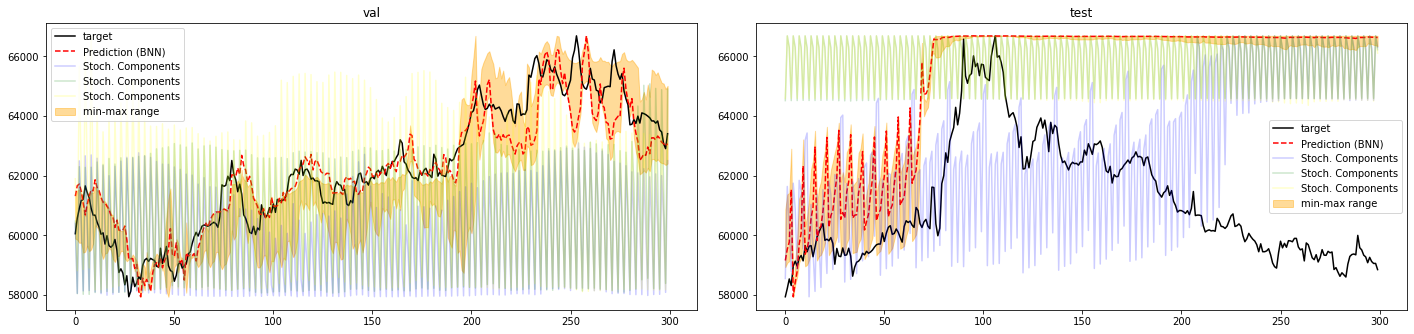

In [86]:

_rate = 300

def Pred_Plot(pred_data, pred_target):

    _ran = min(len(pred_data), 300)
    
    iterations = 10
    
    x_lin = np.arange(0, _ran) 

    predicted = []
    for _ in range(iterations):
        predicted.append(bnn_model(pred_data[:_ran]).numpy())
    predicted = np.concatenate(predicted, axis=1)
    _st = 3
    predicted_three = predicted[:, _st : _st + (_rate//100)] 
    
    prediction_mean = np.mean(predicted, axis=1).tolist()
    prediction_min = np.min(predicted, axis=1).tolist()
    prediction_max = np.max(predicted, axis=1).tolist()
    prediction_range = (np.max(predicted, axis=1) - np.min(predicted, axis=1)).tolist()


    inv_test_pred = inv_norm(prediction_mean)
    inv_test_target = inv_norm(pred_target[:_ran])
    lower = inv_norm(prediction_min)
    upper = inv_norm(prediction_max)
    predicted_three = inv_norm(predicted_three)

    return x_lin, inv_test_pred, inv_test_target, lower, upper, predicted_three


fig, axs = plt.subplots(1, 2, figsize=(20,5))

names = list(data_dict.keys())

ft = time.time()

_color = ['blue', 'green', 'yellow']

for i, nm in enumerate(names[1:]):
    
    k_st = 0
    x_lin, inv_p, inv_t, lower, upper, p_three = Pred_Plot(data_dict[nm][0], data_dict[nm][-1])
    
    inv_t = descale(inv_t, min_og, max_og)
    inv_p = descale(inv_p, min_og, max_og)
    lower = descale(lower, min_og, max_og)
    upper = descale(upper, min_og, max_og)
    p_three = descale(p_three, min_og, max_og)
    
    axs[i].plot(x_lin, inv_t, 'k', label = 'target')
    axs[i].plot(x_lin, inv_p, 'r--',  label = 'Prediction (BNN)')
    for c in _color:
        axs[i].plot(x_lin, p_three[k_st: k_st + _rate], color = c, alpha = 0.2, label = 'Stoch. Components')
        k_st += _rate
    axs[i].fill_between(x_lin, lower, upper, color='orange', alpha=0.4, label = 'min-max range')
    axs[i].set_title(nm)
    axs[i].legend()
    
lt = time.time()
 
print('time-taken: ', (lt - ft)/60, 'mins')

plt.tight_layout(pad = 2)
plt.show()

Test-Performance NOT so Good, Let's do <b> Probabilistic</b> Inferencing instead

### Probabilistic

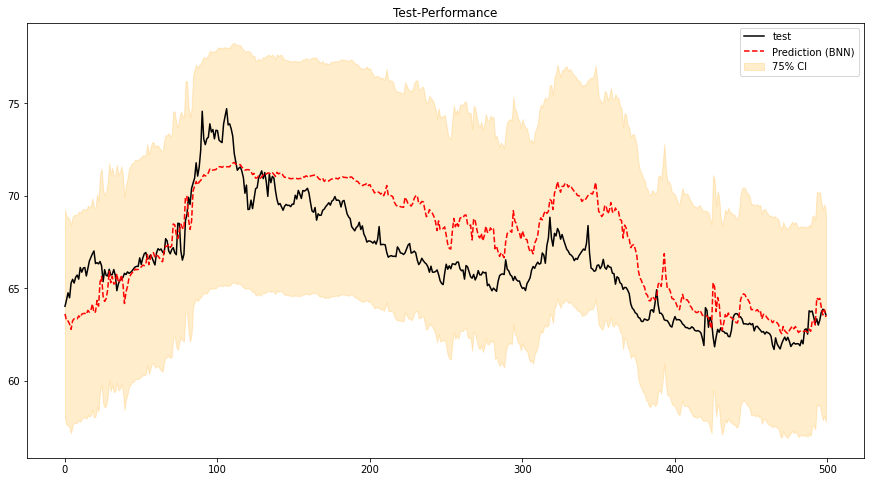

In [324]:
pred_data = test_data
pred_target = test_target
ci = 0.675

_ran = min(len(pred_data), 500)

x_lin = np.arange(0, _ran) 

## Just samples a value at each t from the surrogate posterior distrb.
prediction_distribution = bnn_model(pred_data[:_ran]) ### Gives stochastic value at each time-step (i,e n random variables for n t-steps) for each run
prediction_mean = prediction_distribution.mean().numpy().tolist() ### We get a distribution object, giving seperate distributions for each-time step  
prediction_stdv = prediction_distribution.stddev().numpy()

inv_test_pred = inv_norm(prediction_mean)
inv_test_target = inv_norm(pred_target[:_ran])

inv_test_pred = descale(inv_test_pred, min_og, max_og)
inv_test_target = descale(inv_test_target, min_og, max_og)


# The 75% CI 
upper = (prediction_mean + (ci * prediction_stdv)).tolist()
lower = (prediction_mean - (ci * prediction_stdv)).tolist()

upper = descale(upper, min_og, max_og)
lower = descale(lower, min_og, max_og)

fig = plt.figure(figsize=(15,8))
plt.plot(x_lin, inv_test_target, 'k', label = 'test')
plt.plot(x_lin, inv_test_pred, 'r--',  label = 'Prediction (BNN)')
plt.fill_between(x_lin, inv_norm(lower), inv_norm(upper), color='orange', alpha=0.2, label = '75% CI')
plt.title('Test-Performance')

plt.legend()
plt.show()

In [118]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_target))
mse_error, rmse_error = bnn_model.evaluate(test_data, test_target)

print("MSE-Error (normalized): ", mse_error, ", RMSE-Error (normalized):",rmse_error)

43/43 [==============================] - 0s 5ms/step - loss: 0.3641 - root_mean_squared_error: 0.5237
MSE-Error (normalized):  0.3640826642513275 , RMSE-Error (normalized): 0.5236758589744568


---

SESSION STOPPER

In [ ]:
import time
for i in range(50):
    print('Time: ', i)
    time.sleep(30*60)